In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import spacy
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from transformers import TFAutoModel ,AutoTokenizer, \
    TFBertForSequenceClassification, DataCollatorWithPadding
import tensorflow_hub as hub
import tensorflow_text as text
import pickle

In [14]:
print(tf. __version__)

2.10.0


In [15]:
df_clean = pd.read_csv('data/cleaned_reviews.csv')

In [16]:
df_clean.shape

(17340, 4)

In [17]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [18]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

**Checking for Null Vaules and Duplicates**

In [19]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [20]:
df_clean.dropna(inplace=True)

In [21]:
df_clean.shape

(17337, 2)

In [22]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [23]:
# Mapping was changed due to the use of a neural network architecture
sentiment_mapping = {'negative':0,'neutral':1,'positive':2} 
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)
df_clean.drop(columns=['sentiments'],inplace=True)

In [26]:
# model_checkpoint = "bert_base_cased"
# tokeniser_checkpoint = "bert_base_cased"
model_checkpoint = "../using_transformers/models/bert_base_cased"
tokeniser_checkpoint = "../using_transformers/tokenizers/bert_base_cased"
model = TFAutoModel.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(tokeniser_checkpoint)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ../using_transformers/models/bert_base_cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [27]:
df_clean['cleaned_review'].iloc[0]

'i wish would have gotten one earlier love it and it makes working in my laptop so much easier'

In [115]:
# Exmaple of tokenising
# https://huggingface.co/docs/transformers/v4.26.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus
tokens = tokenizer.encode_plus(
    df_clean['cleaned_review'].iloc[0],
    max_length=20, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    # return_overflowing_tokens=True,
    # return_offsets_mapping=True,
    # stride = 10,
    return_tensors='tf'
)

In [116]:
df_clean['cleaned_review'].iloc[0]

'i wish would have gotten one earlier love it and it makes working in my laptop so much easier'

In [117]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [131]:
tokens.input_ids.numpy().tolist()[0][:20]

[101,
 178,
 3683,
 1156,
 1138,
 4690,
 1141,
 2206,
 1567,
 1122,
 1105,
 1122,
 2228,
 1684,
 1107,
 1139,
 12574,
 1177,
 1277,
 102]

In [136]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=
array([[  101,   178,  3683,  1156,  1138,  4690,  1141,  2206,  1567,
         1122,  1105,  1122,  2228,  1684,  1107,  1139, 12574,  1177,
         1277,   102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

In [132]:
tokens.input_ids #(1,20) 

<tf.Tensor: shape=(1, 20), dtype=int32, numpy=
array([[  101,   178,  3683,  1156,  1138,  4690,  1141,  2206,  1567,
         1122,  1105,  1122,  2228,  1684,  1107,  1139, 12574,  1177,
         1277,   102]])>

In [208]:
from sklearn.model_selection import train_test_split

# y values
labels = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')


X_train, X_test, y_train,y_test= train_test_split(
                                            df_clean['cleaned_review'],labels,test_size=.2,random_state=42, 
                                            stratify=labels)


In [209]:
X_input_ids = np.zeros((len(X_train),300))
X_attn_masks = np.zeros((len(X_train),300))

In [210]:
print(X_input_ids[0])
print(len(X_input_ids)) # 13869 data points
print(X_input_ids[0].shape) # (300,)
print(X_attn_masks[0])
print(len(X_attn_masks)) # 13869 data points
print(X_attn_masks[0].shape) # (300,)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13869
(300,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


In [211]:
X_train.shape

(13869,)

In [212]:
print(X_input_ids[0,:5]) # rows and columns [0,:5], row-1, with 4 columns

[0. 0. 0. 0. 0.]


In [213]:
def generate_ids_masks(X_train,ids,masks,tokeniser):
    for key, text in enumerate(X_train):
        tokenised_text = tokeniser.encode_plus(
                                text,
                                max_length=300, 
                                truncation=True, 
                                padding='max_length', 
                                add_special_tokens=True,
                                return_tensors='tf'
        )
        ids[key,:] = tokenised_text.input_ids # index, value
        masks[key,:] = tokenised_text.attention_mask
    return ids, masks


In [214]:
X_input_ids, X_attn_masks = generate_ids_masks(X_train,
            X_input_ids,
            X_attn_masks,
            tokeniser=tokenizer)

In [215]:
print(X_input_ids)
print(X_attn_masks)

[[  101.   178.  1329. ...     0.     0.     0.]
 [  101.  1122.  1110. ...     0.     0.     0.]
 [  101.   178.  1138. ...     0.     0.     0.]
 ...
 [  101.  1589.  1632. ...     0.     0.     0.]
 [  101.  1103.  1839. ...     0.     0.     0.]
 [  101.  1103. 10322. ...     0.     0.     0.]]
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [216]:
print(X_input_ids[0,:5]) # rows and columns [0,:5], row-1, with 4 columns

[ 101.  178. 1329. 1142. 1114.]


In [217]:
def sentiment_mapping(input_ids, attn_masks, labels):
    return {
        "input_ids":input_ids,
        "attn_masks":attn_masks,
    }, labels

In [218]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids,X_attn_masks,y_train))

In [219]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(300,), dtype=tf.float64, name=None), TensorSpec(shape=(300,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.int8, name=None))>

In [220]:
# converting to required format for tensorflow dataset
dataset = dataset.map(sentiment_mapping)   
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(300,), dtype=tf.float64, name=None), 'attn_masks': TensorSpec(shape=(300,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.int8, name=None))>

In [221]:
# The batch size
# dataset = dataset.batch(16, drop_remainder=True) # batch size, drop any left out tensor
# changed it from 128 to 16 because 
# I want it to be the same as the previously trained approach
formed_dataset= dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [222]:
formed_dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None), 'attn_masks': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 3), dtype=tf.int8, name=None))>

In [223]:
p = 0.8
# for each 16 batch of data we will have len(df)//16 samples, take 80%
# of the train data
train_size = int((len(X_train)//16)*p) 
train_size = int((len(X_train)//16)*p) 

In [224]:
print(len(X_train))
print(train_size)

13869
692


In [225]:
train_dataset = formed_dataset.take(train_size) 
val_dataset = formed_dataset.skip(train_size)  # 42 data points for validation

In [226]:
print(train_dataset,"\n")
print(val_dataset)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None), 'attn_masks': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 3), dtype=tf.int8, name=None))> 

<SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None), 'attn_masks': TensorSpec(shape=(16, 300), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 3), dtype=tf.int8, name=None))>


In [227]:
input_ids = tf.keras.layers.Input(shape=300, name="input_ids", dtype="int32")
attn_masks = tf.keras.layers.Input(shape=300, name="attn_masks", dtype="int32")

In [228]:
bert_embds = model.bert(input_ids,attention_mask=attn_masks)[1]
# 0 -> activation layer (3D), 1 -> pooled output layer (2D)

intermediate_layer1 = tf.keras.layers.Dense(512, activation="relu", name="intermediate_layer1")(bert_embds)
bn_layer1 = tf.keras.layers.BatchNormalization()(intermediate_layer1)
dropout1 = tf.keras.layers.Dropout(0.2)(bn_layer1)
intermediate_layer5 = tf.keras.layers.Dense(64, activation="relu", name="intermediate_layer5")(dropout1)
bn_layer5 = tf.keras.layers.BatchNormalization()(intermediate_layer5)
dropout5 = tf.keras.layers.Dropout(0.2)(bn_layer5)

output_layer = tf.keras.layers.Dense(3,activation="softmax", name="output_layer")(dropout5)

In [229]:
# Freezing the bert model
for layer in model.layers:
    layer.trainable = False

In [230]:
bert_model = tf.keras.Model(inputs=[input_ids,attn_masks], outputs=output_layer)
print(bert_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attn_masks (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attn_masks[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [231]:
# Define the custom callback
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MyCustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get('val_loss') 
            loss = logs.get('loss')
            val_acc = logs.get('val_acc') 
            acc = logs.get('acc')
            if val_loss < 0.4:
                print(f"\nValidation loss is less than 0.4. \nStopping training.\n")
                self.model.stop_training = True
            elif (loss <0.6) and (val_loss <= loss ):
                print(f"\nValidation loss is less than loss: {loss} and loss is less than 0.6\nStopping training.\n")
                self.model.stop_training = True
            elif (val_acc >= 0.75 ) or (val_loss <= 0.55  ):
                print(f"\nValidation loss is <= 0.55 or val_acc >= 0.75\nStopping training.\n")
                self.model.stop_training = True

callback = MyCustomCallback()

In [232]:
import datetime
class TimeCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self,epoch, logs=None):
        print('Epoch: {}, begins at {}\n'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self,epoch, logs=None):
        print('Epoch: {}, ends at {}\n'.format(epoch, datetime.datetime.now().time()))

my_timer = TimeCallback()

In [233]:
# Learning Rate Schedulers
peak_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode= 'min',
    min_lr=0.00001
)

# Learning rate scheduler
def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

my_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# optimizer
optimise = tf.keras.optimizers.Adam(learning_rate=0.01)
# losses
loss = tf.keras.losses.categorical_crossentropy

# metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [234]:
bert_model.compile(optimizer=optimise,
            loss=loss,
            metrics=['acc',precision,recall
            ])

In [235]:
# Model training
tf.keras.backend.clear_session()
bert_model_history = bert_model.fit(
                            train_dataset,
                            epochs=20, 
                            # verbose=1, 
                            # steps_per_epoch=100,
                            validation_data=val_dataset,
                            callbacks=[callback,my_scheduler,
                                       peak_callback,my_timer])

Epoch: 0, begins at 23:25:08.785811

Epoch 1/20
692/692 [==============================] - ETA: 0s - loss: 0.7589 - acc: 0.6720 - precision_3: 0.7028 - recall_3: 0.6159Epoch: 0, ends at 00:25:15.632630

692/692 [==============================] - 3607s 5s/step - loss: 0.7589 - acc: 0.6720 - precision_3: 0.7028 - recall_3: 0.6159 - val_loss: 1.3816 - val_acc: 0.5697 - val_precision_3: 0.5919 - val_recall_3: 0.5600 - lr: 0.0100
Epoch: 1, begins at 00:25:15.662472

Epoch 2/20
692/692 [==============================] - ETA: 0s - loss: 0.6851 - acc: 0.7048 - precision_3: 0.7380 - recall_3: 0.6490Epoch: 1, ends at 01:43:54.139198

692/692 [==============================] - 4718s 7s/step - loss: 0.6851 - acc: 0.7048 - precision_3: 0.7380 - recall_3: 0.6490 - val_loss: 0.8214 - val_acc: 0.7328 - val_precision_3: 0.7336 - val_recall_3: 0.7320 - lr: 0.0100
Epoch: 2, begins at 01:43:54.164560

Epoch 3/20
692/692 [==============================] - ETA: 0s - loss: 0.6624 - acc: 0.7126 - precision_3:

In [236]:
# Test data
X_test_input_ids  = np.zeros((len(X_test),300))
X_test_attn_masks = np.zeros((len(X_test),300))
# print(X_test_input_ids[0])
# print(len(X_test_input_ids)) # 3468 data points
# print(X_test_input_ids[0].shape) # (300,)
# print(X_test_attn_masks[0])
# print(len(X_test_attn_masks)) # 3468 data points
# print(X_test_attn_masks[0].shape) # (300,)


X_test_input_ids, X_test_attn_masks = generate_ids_masks(X_test,
                                                        X_test_input_ids,
                                                        X_test_attn_masks,
                                                        tokenizer)

In [237]:
# Predictions on the Test Set
score = bert_model.evaluate([X_test_input_ids,X_test_attn_masks], y_test, verbose=1)

109/109 [==============================] - 853s 8s/step - loss: 0.5651 - acc: 0.7500 - precision_3: 0.7908 - recall_3: 0.6967


In [238]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5650606155395508
Test Accuracy: 0.75


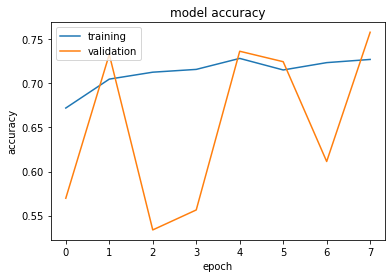

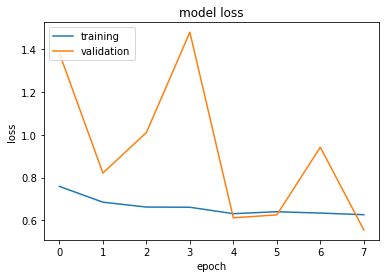

In [239]:
# Model Performance Charts

plt.plot(bert_model_history.history['acc'])
plt.plot(bert_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(bert_model_history.history['loss'])
plt.plot(bert_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

In [240]:
# Saving the model
# bert_model.save("saved_model/bert_model")

### **Classification report**

109/109 [==============================] - 787s 7s/step
              precision    recall  f1-score   support

           0       0.52      0.07      0.13       307
           1       0.67      0.73      0.70      1260
           2       0.81      0.87      0.84      1901

    accuracy                           0.75      3468
   macro avg       0.67      0.56      0.56      3468
weighted avg       0.73      0.75      0.73      3468



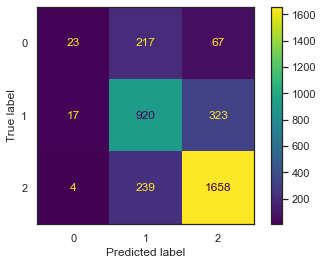

In [241]:
# Classification report test data
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_true=np.argmax(y_test, axis=1)
y_pred_test = bert_model.predict([X_test_input_ids,X_test_attn_masks])
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(bert_model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral ---> 1
# positive --> 2

In [242]:
# Predictions on unseen data

reviews =[ "I can't believe I wasted my money on this keyboard and mouse",
            "I really love this device",
            "It's quite good, but not so great. They can do better",
            "I hate this device, terrible!!!",
            "Where the hell is my refund for this damn product (mouse)",
            "I believe Ebay is so much better than the crap that is HERE!!!",
            "worst keyboard ever",
            "distasteful to the fullest!!!",
            "spoilt on the first day",
            "never shopping here again, waste of money"]

In [244]:
pred_ids = np.zeros((len(reviews),300))
pred_masks = np.zeros((len(reviews),300))
pred_ids,pred_masks = generate_ids_masks(reviews,pred_ids,
                            pred_masks,tokenizer)

In [247]:
pred_ids[0,:10]

array([  101.,   146.,  1169.,   112.,   189.,  2059.,   146., 15445.,
        1139.,  1948.])

In [252]:
y_preds = bert_model.predict([pred_ids,pred_masks])
tf.argmax(y_preds,axis=1)
# np.argmax(y_preds,axis=1)
# New mapping
# negative --> 0
# neutral ---> 1
# positive --> 2

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 2, 1, 1, 1, 1, 0, 1, 1], dtype=int64)>